## Prepare depedencies

In [5]:
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py

--2023-08-03 19:21:31--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23509 (23K) [text/plain]
Saving to: ‘transforms.py’

transforms.py       100%[===================>]  22.96K  --.-KB/s    in 0.002s  

2023-08-03 19:21:31 (14.7 MB/s) - ‘transforms.py’ saved [23509/23509]

--2023-08-03 19:21:31--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K)

## Download Data

In [6]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed.zip -d PennFudanPed

--2023-08-03 19:21:47--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  66.8MB/s    in 0.8s    

2023-08-03 19:21:48 (66.8 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/PennFudanPed/
  inflating: PennFudanPed/PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/PennFudanPed/Annotation/
  inflating: PennFudanPed/PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/PennFudanPed/Annotation/FudanPed00004.txt  


## Data Loader

In [3]:
import os
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.nonzero(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

## Data Transform

In [7]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))

    return T.Compose(transforms)

## Prepare Model

In [8]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 46.0MB/s]


In [9]:
dummy_input = torch.randn((1,3,512,512))
model.eval()
out = model(dummy_input)
# print(out)

## MModify model (optional) added by ferianda, not from template

In [10]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

## Evaluate pipeline Added by ferianda since the evaluation have bug

In [93]:
from coco_utils import get_coco_api_from_dataset
from pycocotools.cocoeval import COCOeval

def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        for p in prediction:
          boxes = p["boxes"]
          boxes = convert_to_xywh(boxes).tolist()
          scores = p["scores"].tolist()
          labels = p["labels"].tolist()

          coco_results.extend(
              [
                  {
                      "image_id": original_id,
                      "category_id": labels[k],
                      "bbox": box,
                      "score": scores[k],
                  }
                  for k, box in enumerate(boxes)
              ]
          )
    return coco_results

def evaluate(model, dataset_test, device):
    cpu_device = torch.device("cpu")
    preds = []
    targets = []
    model.eval()
    for img, target in dataset_test:
        with torch.no_grad():
            pred = model([img.to(device)])
            pred = [{k: v.to(cpu_device) for k, v in t.items()} for t in pred]
            preds.append(pred)
            targets.append(target)

    res = {target["image_id"].tolist()[0]: output for target, output in zip(targets, preds)}
    res = prepare_for_coco_detection(res)

    coco_gt = get_coco_api_from_dataset(dataset_test)
    coco_dt = coco_gt.loadRes(res)
    coco_evaluator = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_evaluator.evaluate()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()


## Train model

In [94]:
from engine import train_one_epoch
import utils

def train():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = PennFudanDataset('PennFudanPed/PennFudanPed', get_transform(train=True))
    dataset_test = PennFudanDataset('PennFudanPed/PennFudanPed', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    # data_loader_test = torch.utils.data.DataLoader(
    #     dataset_test, batch_size=1, shuffle=False, num_workers=4,
    #     collate_fn=utils.collate_fn)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, dataset_test, device)

    print("That's it!")

In [95]:
train()

Epoch: [0]  [ 0/60]  eta: 0:00:51  lr: 0.000090  loss: 0.0991 (0.0991)  loss_classifier: 0.0322 (0.0322)  loss_box_reg: 0.0426 (0.0426)  loss_objectness: 0.0131 (0.0131)  loss_rpn_box_reg: 0.0112 (0.0112)  time: 0.8571  data: 0.3828  max mem: 10290
Epoch: [0]  [10/60]  eta: 0:00:19  lr: 0.000936  loss: 0.1551 (0.1483)  loss_classifier: 0.0446 (0.0412)  loss_box_reg: 0.0671 (0.0716)  loss_objectness: 0.0163 (0.0199)  loss_rpn_box_reg: 0.0129 (0.0157)  time: 0.3867  data: 0.0466  max mem: 10290
Epoch: [0]  [20/60]  eta: 0:00:14  lr: 0.001783  loss: 0.1511 (0.1586)  loss_classifier: 0.0446 (0.0456)  loss_box_reg: 0.0671 (0.0802)  loss_objectness: 0.0174 (0.0180)  loss_rpn_box_reg: 0.0129 (0.0147)  time: 0.3356  data: 0.0121  max mem: 10290
Epoch: [0]  [30/60]  eta: 0:00:10  lr: 0.002629  loss: 0.1188 (0.1619)  loss_classifier: 0.0339 (0.0460)  loss_box_reg: 0.0653 (0.0824)  loss_objectness: 0.0160 (0.0186)  loss_rpn_box_reg: 0.0132 (0.0149)  time: 0.3322  data: 0.0102  max mem: 10290
Epoc

## Add visualization, to help bootcamp participants evaluate the model qualitatively, added by ferianda

In [115]:
img, _ = dataset_test[0]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

print(prediction)

[{'boxes': tensor([[142.2831,  10.4302, 293.6746, 309.6052],
        [ 79.3797,  21.8155, 165.7732, 298.2711],
        [ 52.1945,  21.1964, 224.2725, 295.3693],
        [193.6786,  19.4069, 271.7554, 292.4839],
        [142.3387,   9.8511, 208.9814, 296.8983]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9943, 0.9917, 0.4613, 0.3805, 0.0813], device='cuda:0')}]


x,y,w,h: 142.28305053710938 10.430246353149414 151.39157104492188 299.1749782562256
x,y,w,h: 79.37971496582031 21.81546974182129 86.39349365234375 276.45567893981934
x,y,w,h: 52.194549560546875 21.196413040161133 172.0779266357422 274.17284965515137
x,y,w,h: 193.67861938476562 19.406938552856445 78.0767822265625 273.07694816589355
x,y,w,h: 142.33871459960938 9.851059913635254 66.64273071289062 287.04725551605225


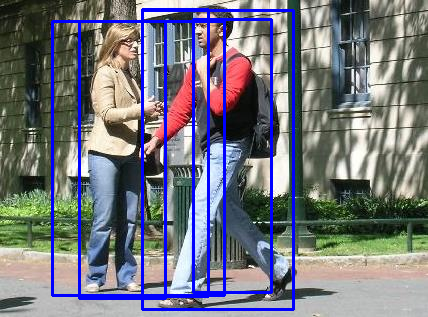

In [135]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

image = img.mul(255).permute(1, 2, 0).byte().numpy()
bboxes = convert_to_xywh(prediction[0]['boxes']).tolist()

for box in prediction[0]['boxes']:
    x,y,w,h = box[0].item() , box[1].item() , box[2].item()  - box[0].item() , box[3].item()  - box[1].item()
    cv2.rectangle(image, (int(x), int(y)), (int(x+w), int(y+h)), (0, 0, 255), 2)
    print("x,y,w,h:",x,y,w,h)

Image.fromarray(image)
